### Taranaki Regional Council: Environmental Data
Taranaki Regional Council make available a variety of environmental data through their website: https://www.trc.govt.nz/environment/maps-and-data/regional-overview
From within each site various data is collected, for example
<ul><li>wind (direction, speed, gust)</li> <li>rainfall</li> <li>river (flow, height, dissolved O2, temperature)</li> <li>soil (moisture, temperature)</li></ul>
Data is available for<ul><li>365 days (daily record)</li> <li>30 days (hourly record)</li><li>7 days (10 minute record)</li></ul>
It is possible to set a starting from date to compile historical data sets from the regional council website.
Although inspecting a data type for a site may offer up a related data type, this is restricted to that which is predetermined in the website.
<br><br>
The following code demonstrates the method for extracting raw data for a small sample of sites and measure types.

In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import requests
import json
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Hard coded lookup tables with a sample of sites and measures available through the TRC website
from src.TRCSampleDF import sites_dataframe, measures_dataframe

# Define url parts for accessing TRC Environmental Data
base_url = "https://www.trc.govt.nz/environment/maps-and-data/site-details/LoadGraphAndListData/"
site_link = "?siteID="
measure_link = "&measureID="
time_link = "&timePeriod="
date_link = "&fromDate="

# Set up dataframes with the id codes that are passed into the url when building the master data dataframe
df_sites = sites_dataframe()
df_measures = measures_dataframe()

# Grab all sites that get data for both wind direction, wind speed and rainfall
df_example = df_sites[(df_sites['wd'] == True) & (df_sites['ws'] == True) & (df_sites['rf'] == True)]
df_example_measures = pd.DataFrame({'id': ['4', '2', '1'], 'measure_id': ['wd', 'ws', 'rf'], 'measure_label': ['Wind Direction', 'Wind Speed', 'Rainfall']})

df_data_full = pd.DataFrame()

# Outer loop is by site
for i in range(0, len(df_example)):
    site_id = str(df_example.iloc[i,0])
    
    # Inner loop is by measure
    for j in range(0, len(df_example_measures)):
        measure_id = df_example_measures.iloc[j,0]
        measure_tag = df_example_measures.iloc[j,1]
        url_link = base_url + site_link + site_id + measure_link + measure_id + time_link + "365days"

        try:
            response = requests.get(url_link)
            response.raise_for_status()
            response_data_string = response.text
            data = json.loads(response_data_string)
            raw_data = data.get('highStockData')
       
            if raw_data:
                df_data = pd.DataFrame(raw_data, columns=['timestamp', 'value'])
                df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], unit='ms')
                df_data['year'] = pd.DatetimeIndex(df_data['timestamp']).year
                df_data['month'] = pd.DatetimeIndex(df_data['timestamp']).month
                df_data['mm-yyyy'] = df_data['timestamp'].apply(lambda x: x.strftime('%Y-%m'))#x.strftime('%B-%y'))
                df_data['site'] = int(site_id)
                df_data['measure'] = measure_tag
        except: pass
        df_data_full = pd.concat([df_data_full, df_data])

df_result = df_data_full.merge(df_sites[['site', 'site_label']], left_on='site', right_on='site')

With the full dataframe now produced, the next step is to create some visuals that aren't available on the TRC website. The first plot is a monthly windrose by site to quickly look for any seasonal pattern on wind direction and wind speed by site.

C:\Users\hamis\AppData\Local\Temp\ipykernel_8200\601428942.py:20: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  maxws_up = int(((maxws / 10) + 1).round().astype(int) * 10)
C:\Users\hamis\AppData\Local\Temp\ipykernel_8200\601428942.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_site['Wind Bin'] = pd.cut(df_site['speed'], bins=bins, labels=labels)
C:\Users\hamis\AppData\Local\Temp\ipykernel_8200\601428942.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

max_freq 13


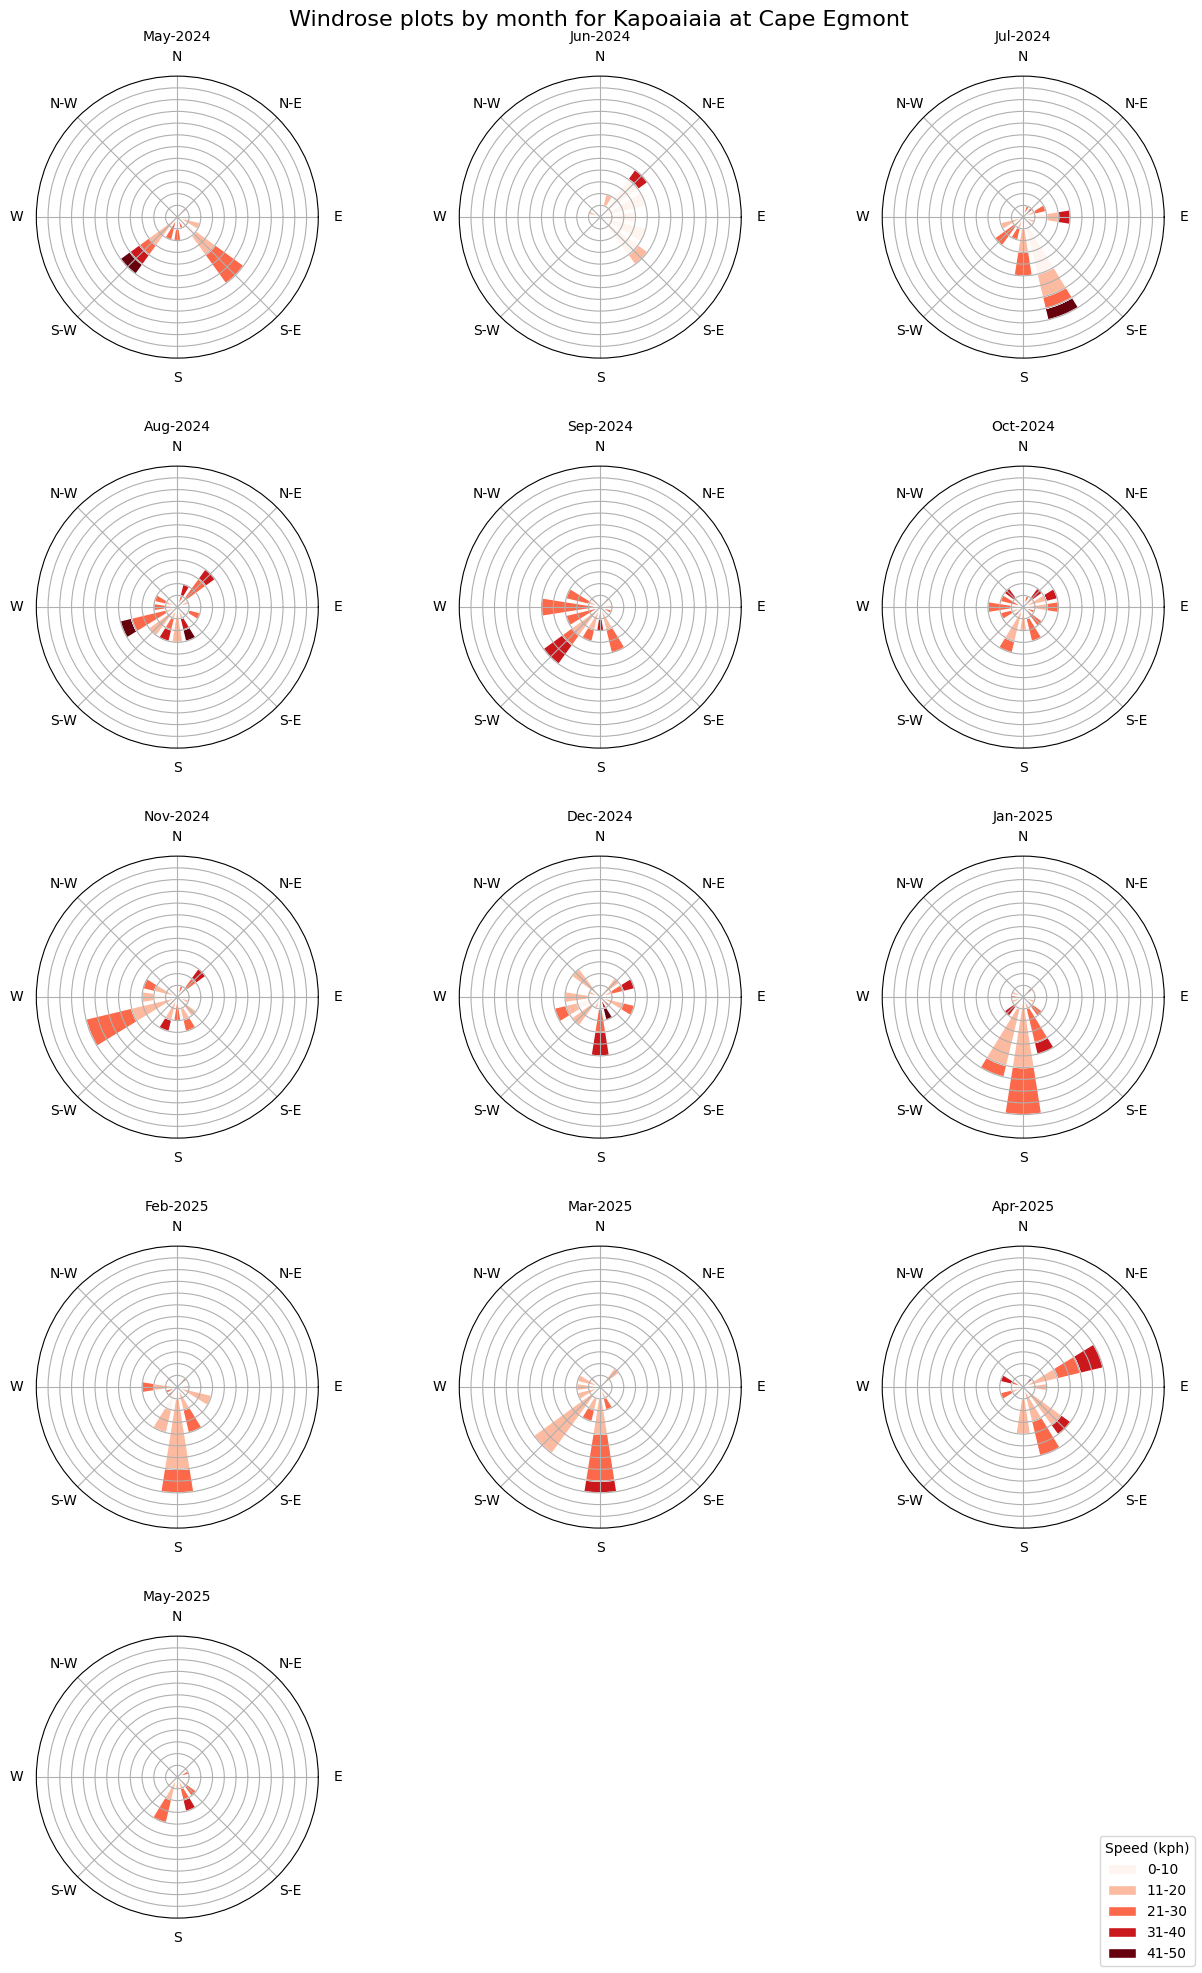

In [20]:
import numpy as np
from windrose import WindroseAxes
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

site = 'Kapoaiaia at Cape Egmont'
df_wide = df_result.pivot_table(
    index=['timestamp', 'mm-yyyy', 'site_label'],
    columns='measure',
    values='value'
).reset_index()

df_wide.columns.name = None
df_wide = df_wide.rename(columns={
    'wd': 'direction',
    'ws': 'speed'
})

maxws = df_wide[['speed']].max()
maxws_up = int(((maxws / 10) + 1).round().astype(int) * 10)

bins = list(range(0, maxws_up, 10))
labels = list(map(lambda x: '0-' + str(x + 10) if x == 0 else str(x + 1) + '-' + str(x + 10) , bins))[:-1]
labels_full = list(map(lambda x: '0-' + str(x + 10) if x == 0 else str(x + 1) + '-' + str(x + 10) , bins))

df_site = df_wide[df_wide['site_label'] == site]
df_site['Wind Bin'] = pd.cut(df_site['speed'], bins=bins, labels=labels)
df_site['mm-yyyy'] = pd.to_datetime(df_site['mm-yyyy'], format="%Y-%m")

nsectors = 16
df_site['Direction Bin'] = pd.cut(
    df_site['direction'] % 360,
    bins=np.linspace(0, 360, nsectors + 1),
    right=False,
    labels=False
)

months = df_site['mm-yyyy'].sort_values().unique()
n_months = len(months)

max_freq = (df_site.groupby(['mm-yyyy','Direction Bin']).size().max())

print(f"max_freq {max_freq}")

ncols = 3
nrows = (n_months + ncols -1) // ncols

fig = plt.figure(figsize=(ncols * 4, nrows * 4))
gs = gridspec.GridSpec(nrows, ncols, figure=fig)
reds = plt.get_cmap('Reds')

for i, month in enumerate(months):
    row = i // ncols
    col = i % ncols
    ax = WindroseAxes(fig, gs[row, col])
    fig.add_axes(ax)
    
    month_data = df_site[df_site['mm-yyyy'] == month]
    ax.bar(
        month_data['direction'],
        month_data['speed'],
        bins=bins,
        label=labels,
        nsector=nsectors,
        edgecolor='white',
        cmap=reds
    )
    ax.set_title(month.strftime("%b-%Y"), fontsize = 10)
    ax.set_ylim(0, max_freq-1)
    ax.set_yticks(range(0, max_freq-1, 1))
    ax.set_yticklabels([])
    #ax.set_legend(title="Speed (kph)",fontsize=8)
    
fig.suptitle(f"Windrose plots by month for {site}", fontsize = 16)
fig.legend(labels_full, title="Speed (kph)", loc="lower right")
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()
